In [ ]:
# gpu guy run this code and make sure weights are saved in /weights folder, then push to repo

In [2]:
import gymnasium as gym
import torch
import time
import numpy as np
import torch.nn.functional as F
from modules import RewardModel, GenerativeModel, ReplayBuffer, DiscreteSACAgent, EpisodicRewardWrapper


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR_POLICY = 3e-4          # Learning rate for actor and critic
LR_GENERATIVE = 3e-4      # Learning rate for generative model
GAMMA = 0.99              # Discount factor
REPLAY_BUFFER_SIZE = 50000 # Size of the replay buffer
BATCH_SIZE = 256          # Batch size for training
TAU = 0.005               # Soft update coefficient for target networks
ALPHA = 0.2               # SAC temperature parameter (entropy regularization)
HIDDEN_DIM = 256          # Hidden dimension for neural networks
MAX_EPISODES = 200       # Total number of episodes to run
MAX_STEPS_PER_EPISODE = 500 # Max steps per episode for CartPole-v1
START_TRAINING_EPISODES = 10 # Number of episodes to collect data before training starts

# Hyperparameters for the GRD generative model loss (L_reg)
# These control the sparsity of the learned causal graph. Increased to encourage sparsity.
LAMBDA_S_R = 5e-4  # state -> reward
LAMBDA_A_R = 1e-5  # action -> reward
LAMBDA_S_S = 5e-5  # state -> state
LAMBDA_A_S = 1e-8  # action -> state


env = gym.make("CartPole-v1")
env = EpisodicRewardWrapper(env)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

compact_state_dim = state_dim 

replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)
generative_model = GenerativeModel(state_dim, action_dim, HIDDEN_DIM, DEVICE, LR_GENERATIVE, GAMMA, LAMBDA_S_S, LAMBDA_S_R, LAMBDA_A_S, LAMBDA_A_R)
sac_agent = DiscreteSACAgent(state_dim, action_dim, compact_state_dim, HIDDEN_DIM, DEVICE, LR_POLICY, TAU, GAMMA, ALPHA)

print(f"Using device: {DEVICE}")
print(f"State dim: {state_dim}, Action dim: {action_dim}")

start_time = time.time()
all_episode_steps = []

rewards = []

for i_episode in range(1, MAX_EPISODES + 1):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    
    episode_reward = 0
    episode_states = []
    episode_actions = []
    
    for t in range(MAX_STEPS_PER_EPISODE):
        with torch.no_grad():
            C_s_s, _, C_s_r, _ = generative_model.causal_module.get_causal_masks(training=False)
            compact_mask = generative_model.causal_module.get_compact_representation_mask(C_s_s, C_s_r)
            compact_state = state * compact_mask

        action = sac_agent.select_action(compact_state)
        
        next_state_np, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # The episodic reward is only non-zero at the end
        # The immediate reward for the replay buffer is this episodic reward if done, else 0
        replay_reward = reward if done else 0.0
        episode_reward += reward 
        
        next_state = torch.tensor(next_state_np, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        
        # Push the transition with the immediate (mostly zero) reward
        replay_buffer.push(state, action, next_state, replay_reward, done)
        episode_states.append(state)
        episode_actions.append(action)
        
        state = next_state

        if len(replay_buffer) > BATCH_SIZE and i_episode > START_TRAINING_EPISODES:
            # Update Generative Model
            generative_model.optimizer.zero_grad()
            transitions = replay_buffer.sample(BATCH_SIZE)
            trajectories = replay_buffer.sample_trajectories(4)
            gen_loss, l_rew, l_dyn, l_reg = generative_model.calculate_loss(trajectories, transitions)
            if torch.is_tensor(gen_loss):
                gen_loss.backward()
                generative_model.optimizer.step()

            # Update Policy Model
            actor_loss, critic_loss = sac_agent.update(transitions, generative_model)

        if done:
            break
    
    all_episode_steps.append(t + 1)

    # After episode ends, store the full trajectory with the final episodic return
    if episode_reward > 0:
        ep_states_tensor = torch.cat(episode_states, dim=0)
        ep_actions_tensor = torch.tensor(episode_actions, device=DEVICE, dtype=torch.long)
        ep_return_tensor = torch.tensor([episode_reward], dtype=torch.float32, device=DEVICE)
        replay_buffer.push_trajectory(ep_states_tensor, ep_actions_tensor, ep_return_tensor)

    if i_episode % 1 == 0:
        avg_steps = np.mean(all_episode_steps[-100:]) # Average over last 100 episodes
        elapsed_time = time.time() - start_time
        print(f"Epi {i_episode}/{MAX_EPISODES} | Avg Steps (last 100): {avg_steps:.2f} | Steps: {t+1} | Time: {elapsed_time:.2f}s")
        print(f"Reward: {episode_reward}")
        rewards.append(episode_reward)
        if len(replay_buffer) > BATCH_SIZE and i_episode > START_TRAINING_EPISODES and torch.is_tensor(gen_loss):
            print(f"  Losses -> Gen: {gen_loss.item():.4f} (Rew: {l_rew.item():.4f}, Dyn: {l_dyn.item():.4f}, Reg: {l_reg.item():.4f})")
            print(f"  Policy -> Actor: {actor_loss:.4f}, Critic: {critic_loss:.4f}")

        with torch.no_grad():
            C_s_s, _, C_s_r, C_a_r = generative_model.causal_module.get_causal_masks(training=False)
            compact_mask = generative_model.causal_module.get_compact_representation_mask(C_s_s, C_s_r)
            s_r_probs = F.softmax(generative_model.causal_module.s_to_r_logits, dim=-1)[:, 1].cpu().numpy()
            a_r_probs = F.softmax(generative_model.causal_module.a_to_r_logits, dim=-1)[:, 1].cpu().numpy()
            print(f"  Causal Probs (S->R): {[f'{p:.2f}' for p in s_r_probs]}")
            print(f"  Compact Mask: {compact_mask.cpu().numpy()}")

env.close()


Using device: cpu
State dim: 4, Action dim: 2
Epi 1/200 | Avg Steps (last 100): 16.00 | Steps: 16 | Time: 0.04s
Reward: 16.0
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0.15']
  Compact Mask: [1. 0. 0. 0.]
Epi 2/200 | Avg Steps (last 100): 14.50 | Steps: 13 | Time: 0.07s
Reward: 13.0
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0.15']
  Compact Mask: [1. 1. 1. 1.]
Epi 3/200 | Avg Steps (last 100): 13.33 | Steps: 11 | Time: 0.11s
Reward: 11.0
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0.15']
  Compact Mask: [1. 1. 1. 0.]
Epi 4/200 | Avg Steps (last 100): 18.50 | Steps: 34 | Time: 0.24s
Reward: 34.0
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0.15']
  Compact Mask: [0. 1. 0. 1.]
Epi 5/200 | Avg Steps (last 100): 17.60 | Steps: 14 | Time: 0.27s
Reward: 14.0
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0.15']
  Compact Mask: [1. 1. 0. 0.]
Epi 6/200 | Avg Steps (last 100): 17.17 | Steps: 15 | Time: 0.30s
Reward: 15.0
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0

d:\duk\RL\Generative-Reward-Decomposition-RL\modules\GenerativeModel.py:51: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rew_losses.append(F.mse_loss(predicted_return, total_return))


Epi 13/200 | Avg Steps (last 100): 20.69 | Steps: 50 | Time: 1.06s
Reward: 50.0
  Losses -> Gen: 101.6207 (Rew: 101.5593, Dyn: 0.0598, Reg: 0.0017)
  Policy -> Actor: -0.5626, Critic: 0.2991
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0.15']
  Compact Mask: [1. 1. 1. 1.]
Epi 14/200 | Avg Steps (last 100): 20.36 | Steps: 16 | Time: 1.64s
Reward: 16.0
  Losses -> Gen: 11.7855 (Rew: 11.7477, Dyn: 0.0362, Reg: 0.0017)
  Policy -> Actor: -1.2190, Critic: 0.4764
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0.15']
  Compact Mask: [1. 1. 1. 1.]
Epi 15/200 | Avg Steps (last 100): 21.00 | Steps: 30 | Time: 2.67s
Reward: 30.0
  Losses -> Gen: 4.9944 (Rew: 4.9206, Dyn: 0.0721, Reg: 0.0017)
  Policy -> Actor: -1.5068, Critic: 0.0750
  Causal Probs (S->R): ['0.29', '0.73', '0.34', '0.15']
  Compact Mask: [1. 1. 1. 1.]
Epi 16/200 | Avg Steps (last 100): 20.31 | Steps: 10 | Time: 3.03s
Reward: 10.0
  Losses -> Gen: 4.4315 (Rew: 4.4189, Dyn: 0.0109, Reg: 0.0017)
  Policy -> Actor: -1.7071, Cri

KeyboardInterrupt: 

In [3]:
rewards

[16.0,
 13.0,
 11.0,
 34.0,
 14.0,
 15.0,
 45.0,
 16.0,
 10.0,
 19.0,
 11.0,
 15.0,
 50.0,
 16.0,
 30.0,
 10.0,
 22.0,
 29.0,
 10.0,
 30.0,
 17.0,
 11.0,
 22.0,
 10.0,
 32.0,
 13.0,
 14.0,
 14.0,
 11.0,
 26.0,
 27.0,
 17.0,
 23.0,
 43.0,
 33.0,
 23.0,
 14.0,
 14.0,
 24.0,
 31.0,
 36.0,
 32.0,
 84.0,
 42.0,
 29.0,
 20.0,
 23.0,
 38.0,
 31.0,
 39.0,
 25.0,
 40.0,
 49.0,
 26.0,
 42.0,
 42.0,
 44.0,
 60.0,
 112.0]

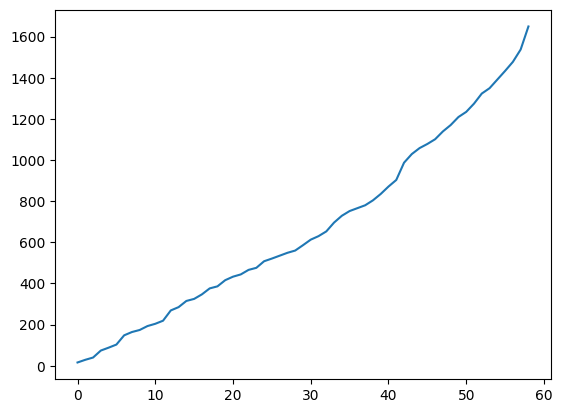

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
nrewards = np.array(rewards, dtype=float)
nrewards = np.cumsum(nrewards)
plt.plot(range(len(nrewards)), nrewards)
plt.show()

with open('weights/rewards.pkl', 'wb') as f:
    pkl.dump(rewards, f)

In [ ]:
sac_agent.save('weights')
